In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import * 
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [8]:
PATH="/home/ubuntu/cjt_fastai/fastai/courses/dl1/data/dogscats/"
sz=224  # images will be resized to this (to speed training?)
print(torch.cuda.is_available())  # check that GPU is setup correctly 
print(torch.backends.cudnn.enabled) # check for accelerated fncs

# ! wget http://files.fast.ai/data/dogscats.zip

True
True


/home/ubuntu/cjt_fastai/fastai/courses/dl1/data/dogscats/
['test1', 'valid', 'models', 'train', 'sample']
['cats', 'dogs']
files: ['cat.1935.jpg', 'cat.12009.jpg', 'cat.6320.jpg', 'cat.2203.jpg', 'cat.3808.jpg']
(499, 412, 3)
[[[102 110 113]
  [107 114 120]
  [111 118 124]
  [110 117 125]]

 [[102 110 113]
  [107 114 120]
  [111 118 124]
  [110 117 125]]

 [[103 111 114]
  [106 113 119]
  [110 117 123]
  [109 116 124]]

 [[103 111 114]
  [106 113 119]
  [108 115 121]
  [108 115 123]]]


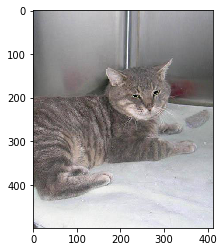

In [10]:
# basic dataset exploration 
print(PATH)
print(os.listdir(PATH))
print(os.listdir(f'{PATH}valid'))
print(f"files: {os.listdir(f'{PATH}valid/cats')[:5]}")
files = os.listdir(f'{PATH}valid/cats')[:5]
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)
print(img.shape)
print(img[:4,:4])


In [11]:
# Start with pretrained resnet module 
# more info: https://github.com/KaimingHe/deep-residual-networks
#... pretrained on ImageNet (1.2 million images with 1000 classes) 
#... resnet34 won the 2015 ImageNet competition
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch,sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.043139   0.025266   0.99      
    1      0.04571    0.025732   0.9885                       



[array([ 0.02573]), 0.98850000000000005]

In [12]:
# look at some results
# 1. few correct labels 
# 2. few incorrect labels 
# 3. most correct labels of each class
# 4. most incorrect of each class
# 5. most uncertain labels

In [13]:
print(np.unique(data.val_y)) # label for validation data 
print(data.classes)  #['cats', 'dogs'] means cats = 0, dogs = 1 
log_preds = learn.predict()  # prediction for validation set
print(log_preds.shape)  # size of prediction matrix 
print(log_preds[:10])

preds = np.argmax(log_preds, axis=1)  # from log probs to 0 or 1 
probs = np.exp(log_preds[:,1])  # P(dog) 

[0 1]
['cats', 'dogs']
(2000, 2)
[[ -0.00001 -11.59642]
 [ -0.00328  -5.72099]
 [ -0.00003 -10.32998]
 [ -0.00068  -7.29785]
 [ -0.00001 -11.44112]
 [ -0.00021  -8.4726 ]
 [ -0.00001 -11.79022]
 [ -0.00012  -9.05124]
 [ -0.00009  -9.27973]
 [ -0.00001 -11.34237]]


In [14]:
# make some helper functions 
def rand_by_mask(mask):
    # get 4 random images from class
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct):
    # get correct images 
    return rand_by_mask((preds==data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0]] for x in idxs)
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(imgs, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for ii in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, ii+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[ii], fontsize=16)
        plt.imshow(imgs[ii])
        
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult*probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds==data.val_y)==is_correct) \
            & (data.val_y==y), mult)

def get_augs(tfms):
    """Show augmentation images"""
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

Correct


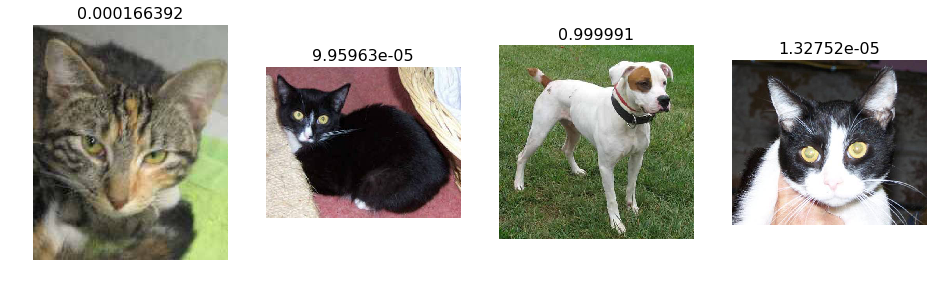

In [15]:
# 1. A few correct labels
plot_val_with_title(rand_by_correct(True), "Correct")


Incorrect


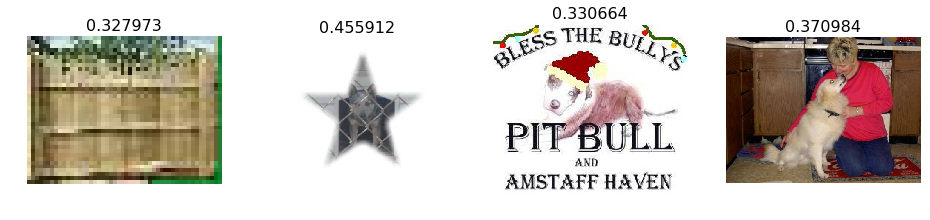

In [16]:
# 2. Incorrect labels 
plot_val_with_title(rand_by_correct(False), "Incorrect")


Most correct cats
Most correct dogs


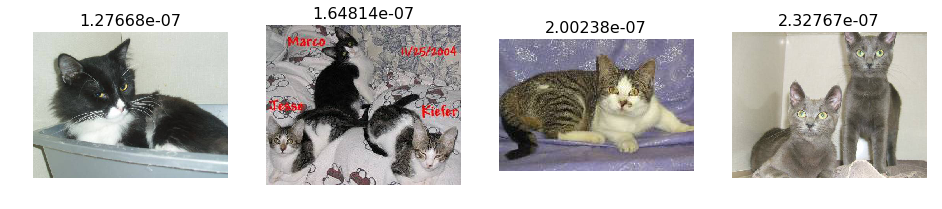

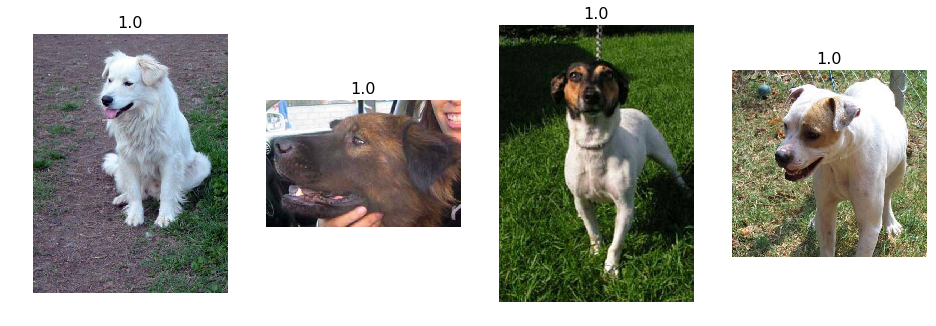

In [17]:
# 3. Most correct 
plot_val_with_title(most_by_correct(0, True), "Most correct cats")
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")


Most incorrect cats
Most incorrect dogs


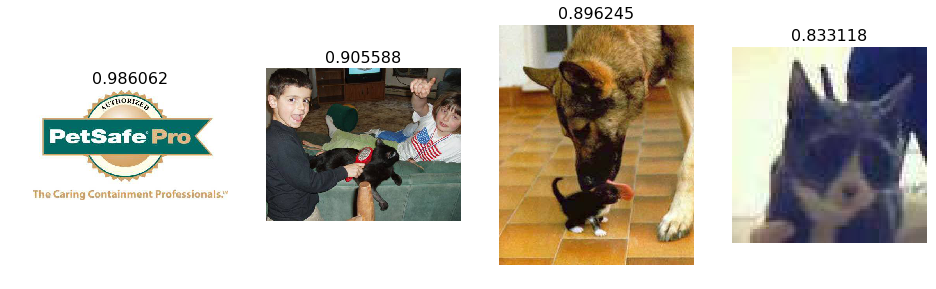

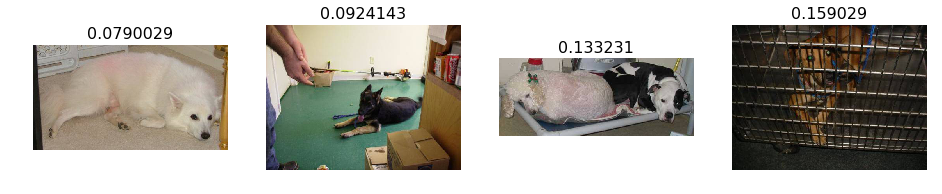

In [18]:
# 4. Most incorrect
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain


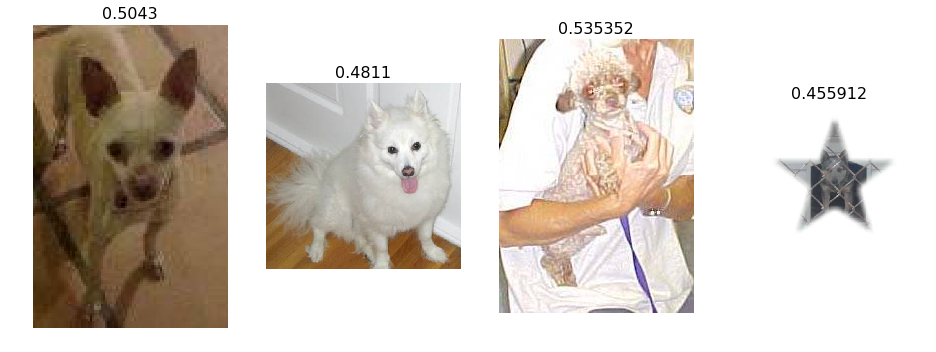

In [19]:
# 5. Most uncertain 
most_uncertain = np.argsort(np.abs(probs - 0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain")

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.062656   0.041092   0.9855    
    1      0.057564   0.029211   0.99                         
    2      0.045066   0.030313   0.9865                       



[array([ 0.03031]), 0.98650000000000004]

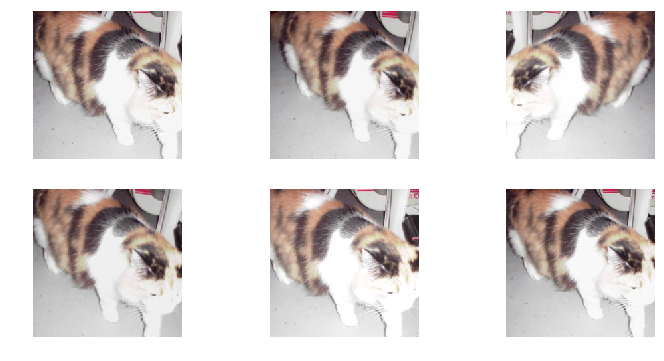

In [20]:
# Improving our model: Data augmentation and learning rate

## data augmentation 
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# show a few
ims = np.stack([get_augs(tfms) for ii in range(6)])
plots(ims, rows=2)

# create new data object with these transforms
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
# learn.fit(1e-2,1)
# turn off precompute to actually let tfms do something (dont' get this yet)
learn.precompute=False 
learn.fit(1e-2, 3, cycle_len=1)

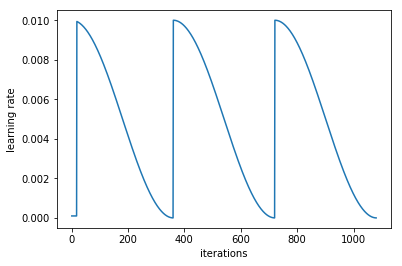

In [21]:
# # set learning rate for (new) untrained model
# learn = ConvLearner.pretrained(arch, data, precompute=True)  
# lrf = learn.lr_find()  # plot learning rate scheduler (for untrained model)
learn.sched.plot_lr()
# learn.sched.plot()

In [22]:
# now we have a well-trained final layer, we can try fine tuning the other layers
learn.unfreeze()
lr = np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.059325   0.030773   0.988     
    1      0.040878   0.021838   0.9905                       
    2      0.034091   0.020956   0.992                        
 38%|███▊      | 137/360 [02:13<03:37,  1.03it/s, loss=0.0284]

KeyboardInterrupt: 

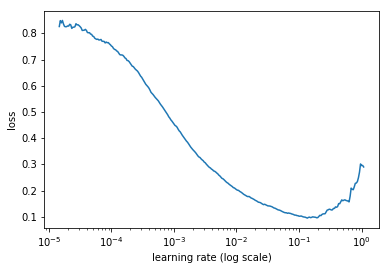

In [42]:
learn.sched.plot_lr()